<a href="https://colab.research.google.com/github/leiyi-ihb/ColabPractics/blob/main/Bug/Dimensions01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import platform
import tensorflow
import keras
print("Platform:{}".format(platform.platform()))
print("Tensorflow version:{}".format(tensorflow.__version__))
print("Keras version:{}".format(keras.__version__))
import numpy as np
from IPython.display import Image

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPool1D
from keras.utils import plot_model

Platform:Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
Tensorflow version:2.9.2
Keras version:2.9.0


In [ ]:
! if [ ! -f "dataset_Li.pkl" ]; then wget https://master.dl.sourceforge.net/project/summer-research-20/sim_data_1/dataset_Li.pkl ; else echo "Found previous downloaded data."; fi

--2022-11-10 16:11:59--  https://master.dl.sourceforge.net/project/summer-research-20/sim_data_1/dataset_Li.pkl
Resolving master.dl.sourceforge.net (master.dl.sourceforge.net)... 216.105.38.12
Connecting to master.dl.sourceforge.net (master.dl.sourceforge.net)|216.105.38.12|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.sourceforge.net/project/summer-research-20/sim_data_1/dataset_Li.pkl [following]
--2022-11-10 16:12:00--  https://downloads.sourceforge.net/project/summer-research-20/sim_data_1/dataset_Li.pkl
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://gigenet.dl.sourceforge.net/project/summer-research-20/sim_data_1/dataset_Li.pkl [following]
--2022-11-10 16:12:00--  https://gigenet.dl.sourceforge.net/project/summer-rese

In [ ]:
# Data processing
import pickle
with open("dataset_Li.pkl", "rb") as f:
    data = pickle.load(f)
x_train, y_train = np.array(data['train'][0]), np.array(data['train'][1])
x_test, y_test = np.array(data['test'][0]), np.array(data['test'][1])
print(x_train.shape, y_train.shape)
print(x_train[0:1, 0:2])

(16000, 1000, 4) (16000, 1)
[[[0. 1. 0. 0.]
  [0. 0. 0. 1.]]]


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000, 4)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 997, 32)           544       
                                                                 
 pool_1 (MaxPooling1D)       (None, 498, 32)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 495, 16)           2064      
                                                                 
 pool_2 (MaxPooling1D)       (None, 247, 16)           0         
                                                                 
 dense (Dense)               (None, 247, 64)           1088      
                                                                 
 output (Dense)              (None, 247, 4)            260 

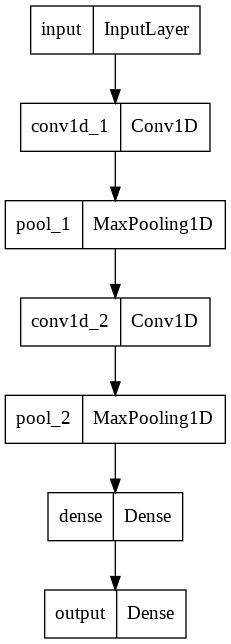

In [ ]:
# 创建网络
input = Input(shape=(1000, 4), name='input')
conv1d_1 = Conv1D(32, kernel_size=4, activation='relu', name='conv1d_1')(input)
pool_1 = MaxPool1D(pool_size=2, name='pool_1')(conv1d_1)
conv1d_2 = Conv1D(16, kernel_size=4, activation='relu', name='conv1d_2')(pool_1)
pool_2 = MaxPool1D(pool_size=2, name='pool_2')(conv1d_2)
hidden1 = Dense(64,activation='relu',name='dense')(pool_2)
output = Dense(4,activation='softmax',name='output')(hidden1)

model = Model(inputs=input, outputs=output)

# 可视化
# 1、打印网络
print(model.summary())
# 2、展示网络结构
plot_model(model,to_file='multiple_inputs.png')
Image('multiple_inputs.png')

In [ ]:
model.compile(optimizer='adam', metrics='acc', loss='mse')
model.fit(x_train, y_train, epochs=10, batch_size=4)
# 可以发现，按照上面的网络搭建方式，这里代码就会报错ValueError: Dimensions must be equal, but are 997 and 4 for。其实错误的发生是因为最后一层Dense的units在本例中没有设置为1。对于二分类问题，最后一层只能有一个输出结果，即只能设置为1
# 要理解清楚，虽然我们的结果为A,T,C或G中的其中一个，但是对于一个而言只可能是其中一个，因此这是个二分类的问题【好好理解】

Epoch 1/10


ValueError: ignored

**基于上面出现的问题，对输入和输出做个探讨**
**1、输入层：**输入层要注意shape的设置。假设x_train多为数组的.shape为(20000, 10000, 20),那么这就是个3维数组，那么输入层的shape=(10000, 20), 这种对应1D卷积；如果x_train多为数组的.shape为(20000, 10000, 20, 5), 那么这就是个4维数组，那么输入层的shape=(10000, 20, 5), 这种对应2D卷积, 就像图片，在这里就表示为20000张，10000x20x5的图片，只不过卷积网络很多都是对长宽相等的图片进行处理而已，这就是为什么网上很多处理图片的例子，输入层的shape=(28, 28, 1)或(25, 25, 3)等的原因。  
那么根据上面的例子，可以知道x_train.shape输出的结果，第一个元素就是batch的大小，这从最后一层batch_size的参数设置中就能看出来。x_train.shape如果为(500, 200, 6)，那么输入shape就为(200, 6), 如果用卷积，只能用1D；x_train.shape如果为(20000, 10000, 500, 200, 6)那么输入的shape就该为(10000, 500, 200, 6), 且应该对应3D卷积  
**2、输出层：**最后一层一般是Dense层的分类输出。Dense的参数设置主要是units和activation。对于units而言，二分类问题只能设置为1，多分类问题一般分几类就设置为几；对于激活函数二分类为sigmoid，对应的损失函数为binary_crossentropy，而多分类一般为softmax，损失函数为categorical_crossentropy[深度学习 | (2) 二分类、多分类与多标签分类的区别与损失函数](https://blog.csdn.net/sdu_hao/article/details/103464286)  
**再看看网络输出中的各种值**
1、Output shape：要明白卷积之后shape的变化。例如你知道为什么第一层卷积的输出为(None, 997,32)吗？None其实是默认的，这个不用管，997是应为原数据为1000, 然后用kernel_size为4,且步长为1的filter扫过一遍，因此应该产生(1000-4+2x0)÷1+1=997个数；那个32其实就是filter的个数[卷积后大小计算](https://blog.csdn.net/Mr_WHITE2/article/details/112334812)   
2、Param: 知道这个怎么得来的吗？[综合_详解keras的model.summary()输出参数output shape 与 Param，计算过程](https://blog.csdn.net/weixin_45330915/article/details/109003798)。按照下面我们看看第一层卷积，就该为(4x4x1+1)x32=544

公式：  
**dense 层**   
Param = （输入数据维度+1）* 神经元个数  
之所以要加1，是考虑到每个神经元都有一个Bias

**Conv1D**  
Param = (卷积核大小 x 词向量维度 + 1) x 卷积核个数  
**Conv2D**  
Param = （卷积核长度*卷积核宽度*通道数+1）x 卷积核个数  
下一层的通道数 = 上一层的卷积核个数  
**klayers.Embedding() ：词嵌入层**   
Param = 词表数*词向量维度

In [ ]:
# 如下修改，就不会有问题了
input = Input(shape=(1000, 4), name='input')
conv1d_1 = Conv1D(32, kernel_size=4, activation='relu', name='conv1d_1')(input)
pool_1 = MaxPool1D(pool_size=2, name='pool_1')(conv1d_1)
conv1d_2 = Conv1D(16, kernel_size=4, activation='relu', name='conv1d_2')(pool_1)
pool_2 = MaxPool1D(pool_size=2, name='pool_2')(conv1d_2)
hidden1 = Dense(64,activation='relu',name='dense')(pool_2)
output = Dense(1,activation='softmax',name='output')(hidden1) # 按理，对于二分类，最后一层输出的激活函数应该为sigmoid

model = Model(inputs=input, outputs=output)

# 可视化
# 1、打印网络
print(model.summary())
# 2、展示网络结构
plot_model(model,to_file='multiple_inputs.png')
Image('multiple_inputs.png')

model.compile(optimizer='adam', metrics='acc', loss='mse') # 按理，二分类对应的loss函数应该为'binary_crossentroy'
model.fit(x_train, y_train, epochs=10, batch_size=4) #可以发现，batch_size为4，就是把16000进行4等分

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000, 4)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 997, 32)           544       
                                                                 
 pool_1 (MaxPooling1D)       (None, 498, 32)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 495, 16)           2064      
                                                                 
 pool_2 (MaxPooling1D)       (None, 247, 16)           0         
                                                                 
 dense (Dense)               (None, 247, 64)           1088      
                                                                 
 output (Dense)              (None, 247, 1)            65  

In [ ]:
# 就按二分类严格来改一下试试
input = Input(shape=(1000, 4), name='input')
conv1d_1 = Conv1D(32, kernel_size=4, activation='relu', name='conv1d_1')(input)
pool_1 = MaxPool1D(pool_size=2, name='pool_1')(conv1d_1)
conv1d_2 = Conv1D(16, kernel_size=4, activation='relu', name='conv1d_2')(pool_1)
pool_2 = MaxPool1D(pool_size=2, name='pool_2')(conv1d_2)
hidden1 = Dense(64,activation='relu',name='dense')(pool_2)
output = Dense(1,activation='sigmoid',name='output')(hidden1) # 按理，对于二分类，最后一层输出的激活函数应该为sigmoid

model = Model(inputs=input, outputs=output)

# 可视化
# 1、打印网络
print(model.summary())
# 2、展示网络结构
plot_model(model,to_file='multiple_inputs.png')
Image('multiple_inputs.png')

model.compile(optimizer='adam', metrics='acc', loss='binary_crossentropy') # 按理，二分类对应的loss函数应该为'binary_crossentropy'
model.fit(x_train, y_train, epochs=10, batch_size=4) #可以发现，batch_size为4，就是把16000进行4等分

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000, 4)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 997, 32)           544       
                                                                 
 pool_1 (MaxPooling1D)       (None, 498, 32)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 495, 16)           2064      
                                                                 
 pool_2 (MaxPooling1D)       (None, 247, 16)           0         
                                                                 
 dense (Dense)               (None, 247, 64)           1088      
                                                                 
 output (Dense)              (None, 247, 1)            65  